In [1]:
import codecs
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [2]:
train_file_name = 'train.txt'
valid_file_name = 'valid.txt'
test_file_name = 'test.txt'

In [3]:
train_label_name = 'train_label.txt'
valid_label_name = 'valid_label.txt'

In [4]:
classes = 16

### Get All Vocabularies and Dictionaries

In [5]:
from collections import Counter

In [6]:
vocab = Counter()

with codecs.open(train_file_name, 'r', encoding='utf8') as f:
    for line in f:
        words = str.split(line, ' ')
        words[-1] = words[-1].strip()
        for word in words:
            vocab[word] += 1

In [7]:
vocab = [word for word,_ in vocab.most_common()]

In [8]:
vocab2num = {}
count = 0
for word in vocab:
    vocab2num[word] = count
    count += 1
vocab2num['<None>'] = count
vocab2num['<Pad>'] = len(vocab2num)

### Load Data

In [9]:
train_sentences = []

with codecs.open(train_file_name, 'r', encoding='utf8') as f:
    for line in f:
        words = str.split(line, ' ')
        words[-1] = words[-1].strip()
        nums = np.array([vocab2num[word] for word in words])
        train_sentences.append(nums)

In [10]:
train_labels = []

with codecs.open(train_label_name, 'r', encoding='utf8') as f:
    for line in f:
        label = int(line)
        train_labels.append(label)

In [11]:
valid_sentences = []

with codecs.open(valid_file_name, 'r', encoding='utf8') as f:
    for line in f:
        words = str.split(line, ' ')
        words[-1] = words[-1].strip()
        
        nums = []
        for word in words:
            try:
                word,tag = str.split(word, '_')
            except:
                continue
                
            if word in vocab2num:
                nums.append(vocab2num[word])
            else:
                nums.append(vocab2num[tag])
                
        if len(nums) == 0:
            nums = [vocab2num['<None>']]
            
        nums = np.array(nums)
        valid_sentences.append(nums)

In [12]:
valid_labels = []

with codecs.open(valid_label_name, 'r', encoding='utf8') as f:
    for line in f:
        label = int(line)
        valid_labels.append(label)

### Prepare Pytorch Data

In [13]:
lens = [len(seq) for seq in train_sentences]
seq_order = sorted(range(len(lens)), key=lens.__getitem__)

In [14]:
train_sentences = [train_sentences[i] for i in seq_order]
train_labels = [train_labels[i] for i in seq_order]

In [21]:
import random

class Sentences(Dataset):
    def __init__(self, sentences, labels, offset, batch_size, drop_words=0.0):
        self.sentences = sentences
        self.labels = labels
        self.random_range = offset * 2 + 1
        self.offset = offset
        self.batch_size = batch_size
        self.drop_words = drop_words
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        random_choice = np.array([0] + random.sample(range(self.random_range), self.batch_size-1)) + idx
        
        if idx < self.offset:
            random_choice = random_choice - idx
        elif idx + self.offset >= len(self.labels):
            random_choice = random_choice - 2*self.offset + (len(self.labels)-idx-1)
        else:
            random_choice = random_choice - self.offset
        random_choice[0] = idx
        
        grouped_sentences = [self.sentences[i] for i in random_choice]
        grouped_labels = np.array([self.labels[i] for i in random_choice])
        
        # randomly drop words
        if self.drop_words > 0.0:
            for i in range(len(grouped_sentences)):
                sent = grouped_sentences[i]
                modified_sent = np.copy(sent)
                for j in range(len(sent)):
                    if np.random.uniform() < self.drop_words:
                        modified_sent[j] = vocab2num['<Pad>']
                grouped_sentences[i] = modified_sent
            
        # pad to same length
        max_len = 0
        for i in range(len(grouped_sentences)):
            sent = grouped_sentences[i]
            max_len = max(max_len, len(sent))
        
        for i in range(len(grouped_sentences)):
            sent = grouped_sentences[i]
            pad_len = max_len-len(sent)
            none_value = vocab2num['<None>']
            grouped_sentences[i] = np.pad(sent, (1,pad_len+1), 'constant', constant_values=(none_value,none_value))
            
        grouped_sentences = torch.tensor(np.array(grouped_sentences).astype(int))
        return grouped_sentences, torch.tensor(grouped_labels)
        

In [22]:
train_dataset = Sentences(train_sentences, train_labels, 1000, 32, 0.15)
valid_dataset = Sentences(valid_sentences, valid_labels, 0, 1)

### Define the Model

In [13]:
class Transpose(nn.Module):
    def __init__(self):
        super(Transpose, self).__init__()

    def forward(self, x):
        return x.transpose(1, 2)

In [14]:
class My_max(nn.Module):
    def __init__(self):
        super(My_max, self).__init__()

    def forward(self, x):
        topk,_ = torch.max(x, 2)
#         print(topk.size())
#         print(topk.view(topk.size(1), -1).size())
        return topk

In [15]:
class Parallel(nn.Module):
    def __init__(self, size1, size2):
        super(Parallel, self).__init__()
        self.conv3 = nn.Sequential(
            nn.Conv1d(size1, size2, 3, 1, 1),
            nn.ReLU(True),
        )
        self.conv5 = nn.Sequential(
            nn.Conv1d(size1, size2, 5, 1, 2),
            nn.ReLU(True),
        )
        
    def forward(self, x):
        conv3 = self.conv3(x)
        conv5 = self.conv5(x)
        return torch.cat([conv3, conv5], 1)

In [16]:
class Model(nn.Module):
    def __init__(self, word_size, classes=classes):
        super(Model, self).__init__()
        self.cnn = nn.Sequential(
            nn.Embedding(word_size, 128),
            Transpose(),
            
            nn.Dropout(0.5),
            
            nn.Conv1d(128, 256, 3, 1, 1),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 256, 3, 2, 1),
            
            nn.BatchNorm1d(256),
            nn.Conv1d(256, 512, 3, 1, 1),
            My_max(),
            
            nn.BatchNorm1d(512),
            
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Linear(512, classes),
        )
        
    def forward(self, x):
        return self.cnn(x)

In [17]:
model = Model(len(vocab2num))
model = model.cuda()
model

Model(
  (cnn): Sequential(
    (0): Embedding(12136, 128)
    (1): Transpose()
    (2): Dropout(p=0.5)
    (3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(256, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): My_max()
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): ReLU(inplace)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): Linear(in_features=512, out_features=16, bias=True)
  )
)

In [18]:
Epoch = 10
LR = 0.001

In [19]:
loss_func = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 

#### Performance Before Train

In [25]:
# validation
correct = 0
total = 0
model.eval()

for b_x, b_y in valid_dataset:
    b_x = b_x.long().cuda()
    b_y = b_y.long().cuda()
    logits = model(b_x)

    # get statistics
    _, predicted_labels = torch.max(logits, 1)
    # print(predicted_labels)
    correct += (predicted_labels == b_y.view(-1)).sum()
    total += len(b_y)

    print('Acc: {}'.format(float(correct)/total), end='\r')

### Train

In [78]:
best_acc = 0.0
val_acc = []

for e in range(Epoch):
    
    # train
    model.train()
    
    orders = np.random.permutation(len(train_dataset))
    train_correct = 0
    train_total = 0
    ave_loss = 0
    loss_n = 0
    
    for i in orders:
        b_x, b_y = train_dataset[i]
        b_x = b_x.long().cuda()
        b_y = b_y.long().cuda()
        logits = model(b_x)
        loss = loss_func(logits, b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # get statistics
        loss_n += 1
        ave_loss += (loss.item() - ave_loss) / loss_n
        _, predicted_labels = torch.max(logits, 1)
        train_correct += (predicted_labels == b_y.view(-1)).sum()
        train_total += len(b_y)
        
        print('Batch:{} Avg Loss:{} Acc:{}'.format(32 * loss_n, 
                ave_loss, float(train_correct)/train_total), end='\r')
        
        if loss_n % 2000 == 0:
    
            print()
            model.eval()
            
            # validation
            valid_correct = 0
            valid_total = 0

            for b_x, b_y in valid_dataset:
                b_x = b_x.long().cuda()
                b_y = b_y.long().cuda()
                logits = model(b_x)

                # get statistics
                _, predicted_labels = torch.max(logits, 1)
                valid_correct += (predicted_labels == b_y.view(-1)).sum()
                valid_total += len(b_y)

                print('Validation Acc: {}'.format(float(valid_correct)/valid_total), end='\r')
                
            acc = float(valid_correct)/valid_total
            val_acc.append(acc)
            if acc > best_acc:
                best_acc = acc
                torch.save((model).state_dict(), 'hw1.t7')
                print('saved')
            else:
                print()
                
            train_correct = 0
            train_total = 0
            ave_loss = 0
            loss_n = 0
            model.train()
        
    print('-------------------------------------------------')

Batch:64000 Avg Loss:1.9960970738530226 Acc:0.36846875865932967
savedation Acc: 0.5676516329704514
Batch:64000 Avg Loss:1.6106005440354332 Acc:0.49881257313656827
savedation Acc: 0.6049766718506998
Batch:64000 Avg Loss:1.436674931466578 Acc:0.55717187552376188
savedation Acc: 0.6765163297045101
Batch:64000 Avg Loss:1.3330963047146818 Acc:0.5926875285142576
savedation Acc: 0.7013996889580093
Batch:64000 Avg Loss:1.2435143761634828 Acc:0.6197031256868434
savedation Acc: 0.7449455676516333
Batch:64000 Avg Loss:1.187034841507672 Acc:0.63571875464232116
Validation Acc: 0.7402799377916018
Batch:64000 Avg Loss:1.1414448472261411 Acc:0.6518759129564783
savedation Acc: 0.7527216174183515
Batch:64000 Avg Loss:1.0996322233378875 Acc:0.6629531259734867
savedation Acc: 0.7573872472783826
Batch:64000 Avg Loss:1.0758463193029124 Acc:0.6706093751195694
savedation Acc: 0.7682737169517885
Batch:64000 Avg Loss:1.058249392792582 Acc:0.67517187522211105
savedation Acc: 0.7838258164852255
Batch:64000 Avg Lo

KeyboardInterrupt: 

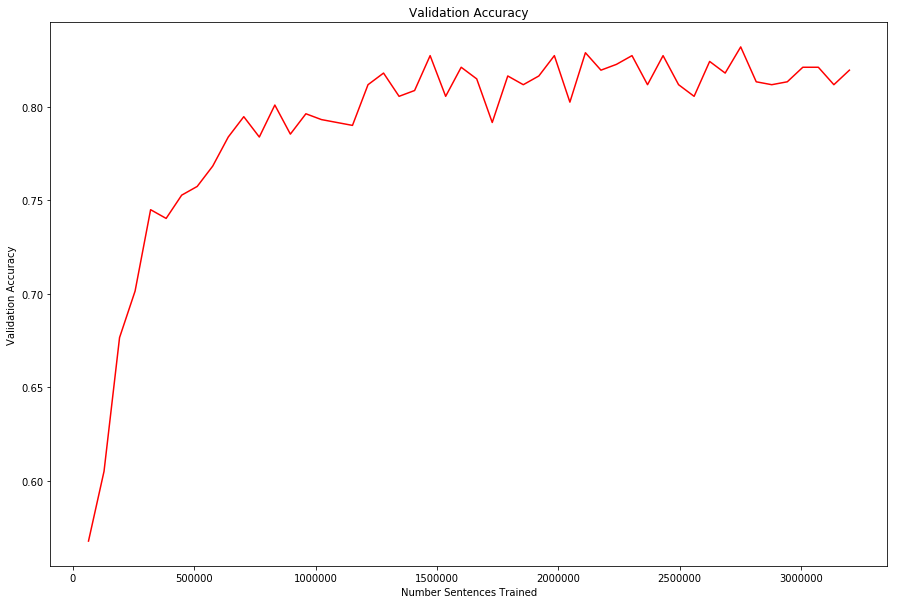

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
x = []
batch = 64000
for i in range(len(val_acc)):
    x.append(batch)
    batch += 64000
plt.plot(x, val_acc, color='r')
plt.xlabel('Number Sentences Trained')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy')
plt.show()

### After Train

In [24]:
model.load_state_dict(torch.load('hw1.t7'))

In [81]:
test_sentences = []

with codecs.open(test_file_name, 'r', encoding='utf8') as f:
    for line in f:
        words = str.split(line, ' ')
        words[-1] = words[-1].strip()
        
        nums = []
        for word in words:
            try:
                word,tag = str.split(word, '_')
            except:
                continue
                
            if word in vocab2num:
                nums.append(vocab2num[word])
            else:
                nums.append(vocab2num[tag])
                
        if len(nums) == 0:
            nums = [vocab2num['<None>']]
            
        nums = np.array(nums)
        test_sentences.append(nums)

In [27]:
class TestSentences(Dataset):
    def __init__(self, sentences):
        self.sentences = sentences
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(np.array(self.sentences[idx]).reshape(1,-1).astype(int))

In [83]:
test_dataset = TestSentences(test_sentences)

In [30]:
num2label = ['Agriculture, food and drink', 'Music', 'Language and literature', 'Geography and places', 'History', 'Art and architecture', 'Video games', 'Mathematics', 'Social sciences and society', 'Natural sciences', 'Philosophy and religion', 'Warfare', 'Media and drama', 'Engineering and technology', 'Sports and recreation', 'Miscellaneous']

In [85]:
model.eval()

with open('result.txt', 'w') as file:
    for sent in test_dataset:
        logits = model(sent.long().cuda())
        _, pred = torch.max(logits, 1)
        pred = pred.item()
        
#         print(pred)
        
        file.write(num2label[pred] + '\n')

In [28]:
valid_test_dataset = TestSentences(valid_sentences)

In [31]:
model.eval()

with open('result_valid.txt', 'w') as file:
    for sent in valid_test_dataset:
        logits = model(sent.long().cuda())
        _, pred = torch.max(logits, 1)
        pred = pred.item()
        
#         print(pred)
        
        file.write(num2label[pred] + '\n')